In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sklearn
import re
from scipy.spatial.distance import jaccard
from sklearn.cluster import SpectralClustering as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial import distance
from networkx.algorithms.community import k_clique_communities,girvan_newman
import itertools


In [2]:
data = pd.read_csv("GawaherSentiment.csv", index_col = 0)
threads = data["ThreadID"].unique()

# Create Graph

In [3]:
def makeGraph(i):
    thread = data[data["ThreadID"] == threads[i]]
    thread = thread.reset_index(drop = True)
    members = thread["MemberID"].unique()
    memberSentiments = []
    memberComments = []

    #encode member names
    index = -1
    for i in range(0,len(members)):
        try:
            int(members[i])
        except:
            thread["MemberID"][thread["MemberID"] == members[i]] = str(index)
            members[i] = str(index)
            index -= 1

    for i in members:
        memberComments.append(len(thread[thread["MemberID"] == i]))
        memberSentiments.append(np.mean(thread[thread["MemberID"] == i]["AllenNLP"]))

    #Make graph
    #Make dictionary of nodes (members) with corresponding mean sentiment of that member
    nodes = np.array(members,dtype = int)
    nodeDict = dict(zip(nodes,np.around(memberSentiments,4)))

    edges = []
    for i in range(0,len(thread)-1):
        if thread["MemberID"].iloc[i] != thread["MemberID"].iloc[i +1]:
            edge = (tuple([int(thread["MemberID"].iloc[i]),int(thread["MemberID"].iloc[i+1])]))
            edges.append(edge)

    sortEdges = [np.sort(x) for x in edges]
    edgeKeys = np.unique(sortEdges,axis=0)
    edgeValues = []

    for i in range(0,len(edgeKeys)):
        count = 0
        for j in range(0,len(sortEdges)):
            count += np.array_equal(sortEdges[j],edgeKeys[i])
        edgeValues.append(count)

    edgeKeys=[tuple(edgeKeys.tolist()[x]) for x in range(0,len(edgeKeys))]
    edgeDict = dict(zip(edgeKeys,edgeValues))

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

In [4]:
def getCommunity(G):
    comp = girvan_newman(G)
    k = 3
    community = []
    for communities in itertools.islice(comp, k):
        community.append(communities)
    return community

C:\Users\Le\AppData\Local\Temp\ipykernel_17044\1507302459.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = str(index)


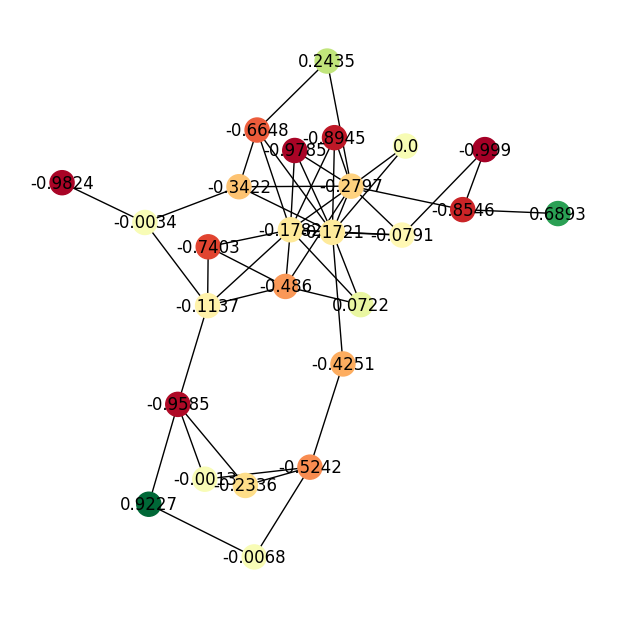

In [5]:

i = 0
thread = data[data["ThreadID"] == threads[i]]
G = makeGraph(i)

memberSentiments = []

for i in thread["MemberID"].unique():
    memberSentiments.append(np.mean(thread[thread["MemberID"] == i]["AllenNLP"]))
    
plt.figure(figsize = (6,6))

pos=nx.kamada_kawai_layout(G)
nodeDict = dict(zip(G.nodes,np.around(memberSentiments,4)))
nx.draw(G, pos = pos, labels = nodeDict, node_color = memberSentiments,  cmap='RdYlGn')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeDict);

# Find Communities

In [6]:
comp = girvan_newman(G)
k = 3
community = []
for communities in itertools.islice(comp, k):
    community.append(communities)

In [14]:
color = np.zeros(len(memberSentiments))

counter = 0
for i in community[-1]:
    color[np.intersect1d(list(G.nodes()), list(i))] = counter
    counter += 1

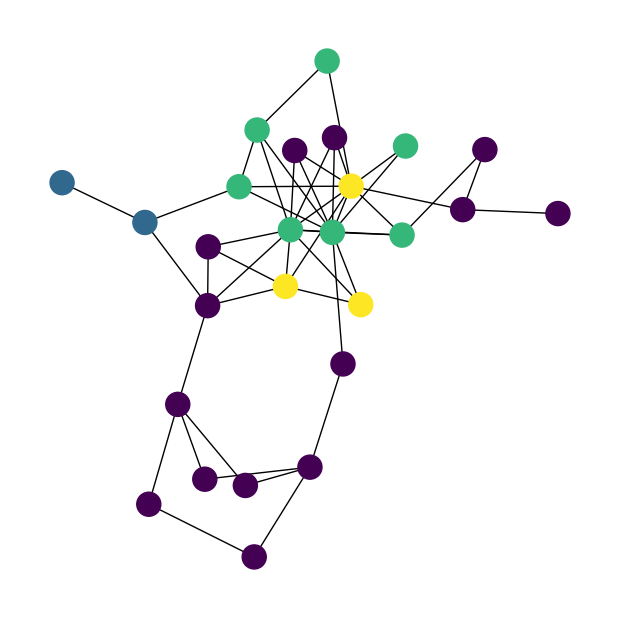

In [15]:
plt.figure(figsize = (6,6))

nx.draw(G, pos = pos, node_color = color)
#nx.draw_networkx_edge(G,pos);
plt.savefig("communities.png")